## CRNN Model

The CRNN (Convolutional Recurrent Neural Network) combines CNN layers for extracting time-frequency features from spectrograms with RNN layers for modeling temporal patterns in the audio signal. This hybrid architecture is well-suited for audio classification tasks because it captures both spatial and sequential information.

In [75]:
import os
import numpy as np
import librosa
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

This function applies random audio augmentation to increase dataset variability and help the model generalize better. Each audio file is randomly transformed using one of several augmentation techniques.

In [95]:
def augment_audio(y, sr):
    choice = random.choice(["none", "pitch", "stretch", "noise"])

    if choice == "none":
        return y, sr
    
    if choice == "pitch":
        n_steps = random.uniform(-2, 2)
        librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    if choice == "stretch":
        rate = random.uniform(0.8, 1.2)
        try:
            y2 = librosa.effects.time_stretch(y, rate)
        except:
            y2 = librosa.effects.time_stretch(y, rate=rate)
        return y2, sr

    if choice == "noise":
        noise = np.random.randn(len(y)) * 0.005
        return y + noise, sr

    return y, sr

This function loads an audio file, optionally augments it, converts it into a 128×128 mel-spectrogram, and pads or crops the time dimension to maintain a fixed input size for the CRNN model.

In [77]:
def load_mel_spectrogram(file_path, augment=False, n_mels=128, max_len=128):
    y, sr = librosa.load(file_path, sr=None)

    if augment:
        y, sr = augment_audio(y, sr)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel = librosa.power_to_db(mel, ref=np.max)

    # Pad or crop to fixed length
    if mel.shape[1] < max_len:
        pad = max_len - mel.shape[1]
        mel = np.pad(mel, ((0,0), (0,pad)))
    else:
        mel = mel[:, :max_len]

    return mel.astype(np.float32)

This block loops through all audio files in your dataset, converts each audio file into a mel-spectrogram, applies augmentation, and stores the processed data in arrays ready for model training.

In [82]:
DATASET_PATH = "../data"
CLASSES = ["dog", "cat", "bird"]

X, Y = [], []

for label in CLASSES:
    folder = os.path.join(DATASET_PATH, label)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            mel = load_mel_spectrogram(path, augment=True)
            X.append(mel)
            Y.append(label)

X = np.array(X)[..., np.newaxis]   # Add channel dimension
Y = np.array(Y)

print("Dataset:", X.shape, Y.shape)

Dataset: (610, 128, 128, 1) (610,)


This block converts string class labels into numerical format, one-hot encodes them for training, and splits the dataset into training and testing sets while preserving class balance.

In [83]:
le = LabelEncoder()
Y_enc = le.fit_transform(Y)
Y_cat = tf.keras.utils.to_categorical(Y_enc)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y_cat, test_size=0.2, random_state=42, stratify=Y_cat
)

This function builds a Convolutional Recurrent Neural Network (CRNN), which combines CNN layers for extracting spectrogram features and GRU layers for modeling temporal patterns. This architecture is well-suited for audio classification.

In [84]:
def build_crnn(input_shape, num_classes):
    inp = tf.keras.Input(shape=input_shape)

    # CNN feature extractor
    x = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    # Reshape for RNN (time-major)
    shape = x.shape
    x = tf.keras.layers.Reshape((shape[1], shape[2]*shape[3]))(x)

    # RNN layers
    x = tf.keras.layers.GRU(64, return_sequences=True)(x)
    x = tf.keras.layers.GRU(32)(x)

    x = tf.keras.layers.Dense(64, activation="relu")(x)
    out = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inp, out)
    return model

model = build_crnn((128,128,1), len(CLASSES))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 32, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32, 64)         │       405,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,803 (1.67 MB)

 Trainable params: 436,611 (1.67 MB)

 Non-trainable params: 192 (768.00 B)

This block freezes the CNN layers of the CRNN model and trains only the RNN and Dense layers first. This acts like a “warm-up” phase that stabilizes training and helps prevent overfitting, especially on small datasets.

In [85]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = False

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy"]
)

history_1 = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=25,
    batch_size=32
)

Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.2893 - loss: 1.1300 - val_accuracy: 0.3469 - val_loss: 1.1157
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.3417 - loss: 1.0996 - val_accuracy: 0.3265 - val_loss: 1.0990
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.4032 - loss: 1.0822 - val_accuracy: 0.3265 - val_loss: 1.0820
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.4647 - loss: 1.0602 - val_accuracy: 0.4490 - val_loss: 1.0634
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.4556 - loss: 1.0381 - val_accuracy: 0.5102 - val_loss: 1.0480
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.4943 - loss: 0.9819 - val_accuracy: 0.4082 - val_loss: 1.0479
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.5718 - loss: 0.9013 - val_accuracy: 0.4490 - val_loss: 1.0576
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.5444 - loss: 0.8848 - val_accuracy: 0.

This block unfreezes all layers of the CRNN (including the CNN feature extractor) and fine-tunes the entire model using a smaller learning rate. This allows the model to make more precise adjustments after the RNN layers have already learned stable temporal patterns.

| Training Phase                                  | What Happens                                  | Learning Rate     | Which Layers Train? | Purpose                                             |
| ----------------------------------------------- | --------------------------------------------- | ----------------- | ------------------- | --------------------------------------------------- |
| **Phase 1 (history_1)**<br>Frozen CNN           | CNN **frozen**, only GRU + Dense layers train | **1e-3** (higher) | RNN + Dense         | Stabilizes training, learns temporal patterns first |
| **Phase 2 (history_2)**<br>Fine-tune all layers | CNN **unfrozen**, entire model trains         | **1e-4** (lower)  | CNN + RNN + Dense   | Fine-tunes all layers for best accuracy             |

In [86]:
for layer in model.layers:
    layer.trainable = True

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),  # smaller LR
    metrics=["accuracy"]
)

history_2 = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.7813 - loss: 0.4913 - val_accuracy: 0.6327 - val_loss: 0.7491
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.7813 - loss: 0.4642 - val_accuracy: 0.6531 - val_loss: 0.7953
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.7813 - loss: 0.4542 - val_accuracy: 0.5918 - val_loss: 0.7311
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.8064 - loss: 0.4404 - val_accuracy: 0.6327 - val_loss: 0.7187
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.8087 - loss: 0.4330 - val_accuracy: 0.6327 - val_loss: 0.7260
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.8200 - loss: 0.4435 - val_accuracy: 0.6327 - val_loss: 0.7375
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.8018 - loss: 0.4435 - val_accuracy: 0.6327 - val_loss: 0.7606
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.8337 - loss: 0.4172 - val_accuracy: 0.

In [96]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7049 - loss: 0.9564

Test Accuracy: 70.49%


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


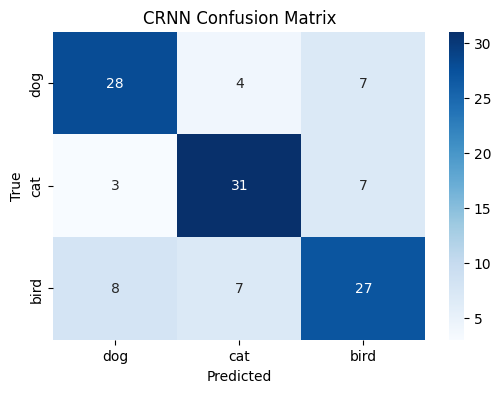

In [97]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CRNN Confusion Matrix")
plt.show()

In [99]:
def predict_audio(file_path):
    mel = load_mel_spectrogram(file_path, augment=False)
    mel = mel[np.newaxis, ..., np.newaxis]
    pred = model.predict(mel)
    idx = np.argmax(pred)
    return le.classes_[idx]

print("Prediction:", predict_audio("../data/dog/1c3f50ad_nohash_1.wav"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: dog
